# SIPRI MIlitary Expenditure dataset

## Carrie Little

### Import Necessary Libraries

In [1]:
# Import All Necessary Libraries
import numpy as np                   
import pandas as pd   
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats          
import cvxpy as cp
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load Dataset
# Define the file path
file_path = Path("..") / "data" / "Cleaned_merged_SIPRI_Region_ACLED_starting2000.csv"     # Suitable for within Github repository
# file_path = 'Cleaned_merged_SIPRI_Region_ACLED_starting2000.csv'                         # for when working in same directory

# Load the CSV file
df = pd.read_csv(file_path)
#data = pd.read_csv(file_path)
                       
df.head()                                                                  

,Country,Year,Expenditure-Share_of_Govt_spending,Expenditure-Share_of_GDP,Expenditure_Per_Capita,Expenditure_Constant_2022,Region,Subregion,index_level,total_rank_from_avg_rank,...,total_score_rank,Deadliness_raw,Diffusion_raw,Danger_raw,Fragmentation_raw,Deadliness_scaled,Diffusion_scaled,Danger_scaled,Fragmentation_scaled,total_score
0,Brazil,2000,NaN,0.017307,64.500907,15643.43168,Americas,South America,1,6,...,6,6678,0.003,4117,67,0.167247,0.004342,0.635536,0.044108,0.851
1,Brazil,2001,0.047167,0.019519,61.332747,18119.43481,Americas,South America,1,6,...,6,6678,0.003,4117,67,0.167247,0.004342,0.635536,0.044108,0.851
2,Brazil,2002,0.041112,0.018958,53.550103,18361.33076,Americas,South America,1,6,...,6,6678,0.003,4117,67,0.167247,0.004342,0.635536,0.044108,0.851
3,Brazil,2003,0.035175,0.015035,45.956041,14647.82954,Americas,South America,1,6,...,6,6678,0.003,4117,67,0.167247,0.004342,0.635536,0.044108,0.851
4,Brazil,2004,0.035561,0.014613,52.945029,15219.74744,Americas,South America,1,6,...,6,6678,0.003,4117,67,0.167247,0.004342,0.635536,0.044108,0.851


In [3]:
# Drop unnecessary columns
columns_to_drop = [
    'Deadliness_scaled', 'Diffusion_scaled', 'Danger_scaled', 'Fragmentation_scaled',
    'Deadliness_rank', 'Diffusion_rank', 'Danger_rank', 'Fragmentation_rank',
    'Deadliness_raw', 'Diffusion_raw', 'Danger_raw', 'Fragmentation_raw'
]
df.drop(columns=columns_to_drop, inplace=True)

In [4]:
# Handling missing values in "Expenditure_Constant_2022" using forward and backward filling
df['Expenditure_Constant_2022'] = df['Expenditure_Constant_2022'].ffill().bfill()

# Handling missing values in other numerical columns using median imputation
for column in ['Expenditure-Share_of_Govt_spending', 'Expenditure-Share_of_GDP', 'Expenditure_Per_Capita']:
    median_value = df[column].median()
    df[column] = df[column].fillna(median_value)

# Verify that there are no missing values left in the dataset
missing_values_after_imputation = df.isna().sum()
missing_values_after_imputation[missing_values_after_imputation > 0]

Series([], dtype: int64)

In [5]:
# Encoding categorical features (Region, Subregion)
df = pd.get_dummies(df, columns=['Region', 'Subregion'], drop_first=True)

# Feature Selection
X = df.drop(['Country', 'Year', 'Expenditure_Constant_2022'], axis=1)
y = df['Expenditure_Constant_2022']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training - Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Model Training - Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [6]:
# Model Evaluation
def evaluate_model(model, X_test, y_test):
    r2_score = model.score(X_test, y_test)
    print(f"R^2 Score: {r2_score}")

print("Linear Regression Evaluation:")
evaluate_model(linear_model, X_test, y_test)

print("Random Forest Evaluation:")
evaluate_model(rf_model, X_test, y_test)

Linear Regression Evaluation:
R^2 Score: 0.43954376131158035
Random Forest Evaluation:
R^2 Score: 0.9969161778315511


Analysis of Evaluation Results
Linear Regression Evaluation:
R^2 Score: 0.4395 (approximately 0.44)
This means that the Linear Regression model explains around 44% of the variance in the test data.
A score of 0.44 is moderate, indicating that the model captures some of the relationships between features and the target variable but leaves a lot of the variance unexplained.
This could mean that:
The relationship between the features and the target is non-linear.
The features used may not be fully capturing all the patterns present in the target variable.
There may be other complex interactions or features that are missing.
Random Forest Evaluation:
R^2 Score: 0.9969 (approximately 0.997)
The Random Forest model explains 99.7% of the variance in the test data, which is very close to a perfect fit.
This suggests that the Random Forest model has captured almost all of the variability in the target variable and is making highly accurate predictions.

Such a high R^2 score might indicate:
Good Fit: Random Forest is a flexible, non-linear model that can capture complex relationships between features and the target variable.
Overfitting Concern: When anR^2 score is very close to 1, especially on the test set, it might also suggest that the model could be overfitting — meaning that it might be memorizing the data rather than generalizing well. This could lead to poor performance on completely new data.

#### Random Forest Hyperparameter Tuning

In [7]:
# Re-import necessary libraries and load the dataset again
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [8]:
# Load Dataset
# Define the file path
file_path = Path("..") / "data" / "Cleaned_merged_SIPRI_Region_ACLED_starting2000.csv"     # Suitable for within Github repository
# file_path = 'Cleaned_merged_SIPRI_Region_ACLED_starting2000.csv'                         # for when working in same directory

# Load the CSV file
#df = pd.read_csv(file_path)
data = pd.read_csv(file_path)

# df.index.name = 'index'
data.index.name = 'index'

In [9]:
# Remove unnecessary columns that are not relevant for forecasting
columns_to_drop = [
    'Deadliness_scaled', 'Diffusion_scaled', 'Danger_scaled', 'Fragmentation_scaled',
    'Deadliness_rank', 'Diffusion_rank', 'Danger_rank', 'Fragmentation_rank'
]
data_cleaned = data.drop(columns=columns_to_drop, errors='ignore')

In [10]:
# Handling missing values
data_cleaned = data_cleaned.copy()
data_cleaned['Expenditure_Constant_2022'] = data_cleaned['Expenditure_Constant_2022'].ffill().bfill()
for column in ['Expenditure-Share_of_Govt_spending', 'Expenditure-Share_of_GDP', 'Expenditure_Per_Capita']:
    median_value = data_cleaned[column].median()
    data_cleaned[column] = data_cleaned[column].fillna(median_value)

In [11]:
# Remove non-numeric columns for the feature set preparation
numeric_columns = data_cleaned.select_dtypes(include=[np.number]).columns

# Feature selection and data preparation
features = [
    'Year', 'index_level', 'total_rank_from_avg_rank', 'total_score_rank',
    'Deadliness_raw', 'Diffusion_raw', 'Danger_raw', 'Fragmentation_raw',
    'Expenditure-Share_of_Govt_spending', 'Expenditure-Share_of_GDP', 'Expenditure_Per_Capita'
]
features = [feature for feature in features if feature in numeric_columns]

target = 'Expenditure_Constant_2022'

In [ ]:
# Prepare the feature set and target vector
data_for_model = data_cleaned[['Country', 'Year', target] + features].dropna()

# Convert the 'Year' column to integers to avoid any data type inconsistencies
data_for_model['Year'] = data_for_model['Year'].astype(int)

# Remove any rows with missing 'Year' values to ensure consistency
data_for_model = data_for_model.dropna(subset=['Year'])

# Extract the latest year for each country using groupby and then merge to get the latest expenditure data
latest_year_per_country = data_for_model.groupby('Country')['Year'].max().reset_index()

# Drop extra 'Year' columns to avoid duplicates
data_for_merge = data_for_model.drop(columns=['Year'])

# Merge back to get data for the latest year for each country
latest_expenditure = pd.merge(data_for_merge, latest_year_per_country, on=['Country'], how='inner')

# Get the top 15 countries based on the latest expenditure values
top_15_countries = latest_expenditure.groupby('Country')[target].max().nlargest(15).index
# Filter the data for the top 15 countries
top_15_data = data_for_model[data_for_model['Country'].isin(top_15_countries)]

# Prepare feature matrix (X) and target vector (y)
X = top_15_data[features]
y = top_15_data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Defining the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2,
                           scoring='r2')

# Fitting GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Displaying the best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Using the best estimator to evaluate on the test data
best_rf_model = grid_search.best_estimator_
r2_score = best_rf_model.score(X_test, y_test)
print(f"R^2 Score for the best Random Forest model: {r2_score}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R^2 Score for the best Random Forest model: 0.9955922371327366

#### Tuned Random Forest Model

In [13]:
# Initialize the Random Forest Regressor with the tuned parameters
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    max_features='sqrt', 
    min_samples_leaf=1, 
    min_samples_split=2, 
    random_state=42
)

# Fit the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Evaluate the model on the test data
r2_score = rf_model.score(X_test, y_test)
print(f"R^2 Score for the tuned Random Forest model: {r2_score}")

R^2 Score for the tuned Random Forest model: 0.9955922371327366


The difference between the $R^2$ score of the initial Random Forest model (0.9969) and the tuned Random Forest model (0.9956) is minimal, indicating that both models perform similarly well in capturing the variance of the target variable. 

1. Model Complexity and Generalization
The initial Random Forest model was trained with default parameters, which allowed a higher complexity (e.g., no limit on max_depth and larger number of features considered for each split).
Tuning Parameters for Generalization: The tuned model has constraints such as:
max_depth=10: Limits how deep each decision tree can grow, thereby reducing model complexity.
max_features='sqrt': Limits the number of features considered at each split, reducing the chance of overfitting.
These tuned parameters were intended to create a model that generalizes better by reducing overfitting. However, limiting complexity might slightly reduce the training accuracy, which could explain the slightly lower 
$R^2$ score for the tuned model.

2. Overfitting vs. Generalization Trade-Off
Initial Model: Without specific constraints (e.g., max_depth or max_features), the initial Random Forest model had more freedom to grow very deep and potentially overfit the training data.
A high $R^2$ value close to 1 is often a sign that the model might be overfitting, especially if it performs almost perfectly.
Overfitting means the model captures not only the true underlying patterns but also the noise, leading to lower generalizability to unseen data.
Tuned Model: The tuning focused on reducing the possibility of overfitting by limiting tree depth and feature selection.
Slight Reduction in Performance: The $R^2$ score dropped slightly from 0.9969 to 0.9956. This small reduction suggests that the model may now be sacrificing a bit of training accuracy for improved generalizability.

3. Parameter Tuning Effects
The tuned parameters are set to prevent the model from becoming too complex:
max_depth=10: Limits the tree depth, preventing overfitting by reducing the likelihood of fitting specific noise or minor fluctuations in the data.
min_samples_split=2 and min_samples_leaf=1: These values are relatively lenient and allow the model to split nodes and create leaf nodes even with minimal data.
max_features='sqrt': This is often a good choice for Random Forests to create diversity among the trees, which helps in reducing overfitting.
Overall, these constraints simplify the model, which might slightly reduce its capacity to capture every nuance in the training data. However, this simplification generally results in better generalization to new data.

4. Randomness in Model Training
Random Component: Random Forests introduce randomness through both data sampling (bootstrapping) and feature selection at each split.
Random State Influence: Even with the same random_state, different hyperparameters can lead to slight variations in how the model performs due to changes in how decision trees are constructed.

5. Cross-Validation Considerations
The hyperparameters were tuned using cross-validation (cv=3), which helps assess model performance across different splits of the training data.
Cross-validation provides a better estimation of generalizability, and a slightly lower score could mean the model is performing more consistently across the folds, rather than fitting specific folds particularly well.
Summary
The initial model was likely more complex and fit the data better, leading to a slightly higher $R^2$ score. However, this also raises concerns about potential overfitting.
The tuned model was intentionally constrained to promote better generalization by limiting tree depth and the number of features considered, resulting in a slight reduction in the $R^2$ score.
The difference between 0.9969 and 0.9956 is negligible in practical terms, suggesting that both models perform very well, but the tuned model is expected to be less prone to overfitting and thus more reliable when applied to unseen data.
To further confirm which model generalizes better, you could:

Evaluate on a completely separate validation set.
Use cross-validation on the test set to get a more consistent performance metric.
The slight decrease in$R^2$ indicates that the tuning is likely making the model more robust, which is usually preferred over an almost-perfect fit that risks overfitting.

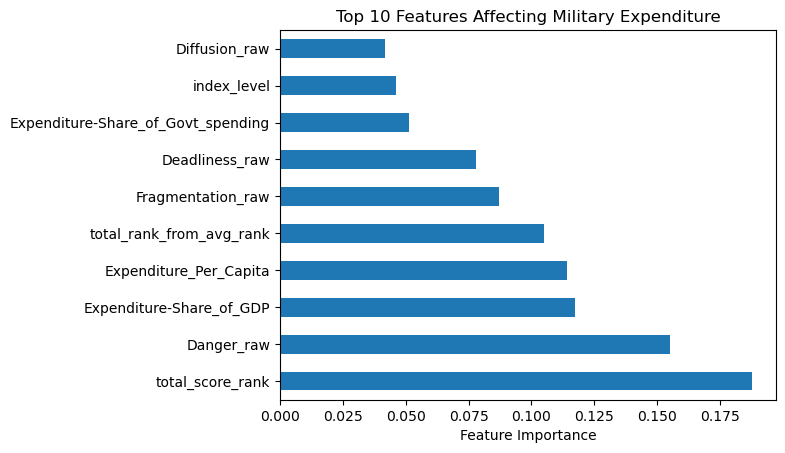

In [14]:
# Feature Importance Analysis (for Random Forest)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features Affecting Military Expenditure")
plt.xlabel("Feature Importance")
plt.show()

Key Observations:

Top Feature - total_score_rank:
The feature with the highest importance is total_score_rank, with an importance of around 0.18.
This suggests that total_score_rank is the most significant predictor of military expenditure in the model.

High-Importance Features:
Danger_raw, Expenditure-Share_of_GDP, and Expenditure_Per_Capita also have relatively high importance values, indicating that they significantly contribute to predicting military expenditure.

Specifically:
Danger_raw: This feature likely captures an element of perceived threat or danger, making it influential in determining expenditure.
Expenditure-Share_of_GDP: This feature’s importance suggests that countries’ decisions on military spending are closely tied to their GDP performance.

Moderately Important Features:
Features such as total_rank_from_avg_rank, Fragmentation_raw, and Deadliness_raw also show a moderate level of importance.
These features likely provide additional context for understanding the nature of the threats and conflicts that influence military expenditure decisions.

Lower Importance Features:
Features like Expenditure-Share_of_Govt_spending, index_level, and Diffusion_raw have lower importance scores.
Although they still contribute to the model, their impact is much less compared to the top-ranked features.

Summary:
total_score_rank is the most influential feature, highlighting its strong correlation with military expenditure.
Features related to GDP, perceived danger, and specific rankings (total_score_rank, total_rank_from_avg_rank) significantly impact military spending.
Other factors such as fragmentation and deadliness also play a role but to a lesser extent.

In [15]:
# Show predictions of the Random Forest model
predictions = rf_model.predict(X_test)

# Create a DataFrame to compare actual vs predicted values
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})

predictions_df.head()

,Actual,Predicted
index,,
3608,46897.50895,46986.231823
1140,20627.07245,23242.458146
3678,615755.93240,625818.797038
2935,69196.88482,75655.604037
3593,29352.65461,29520.882210


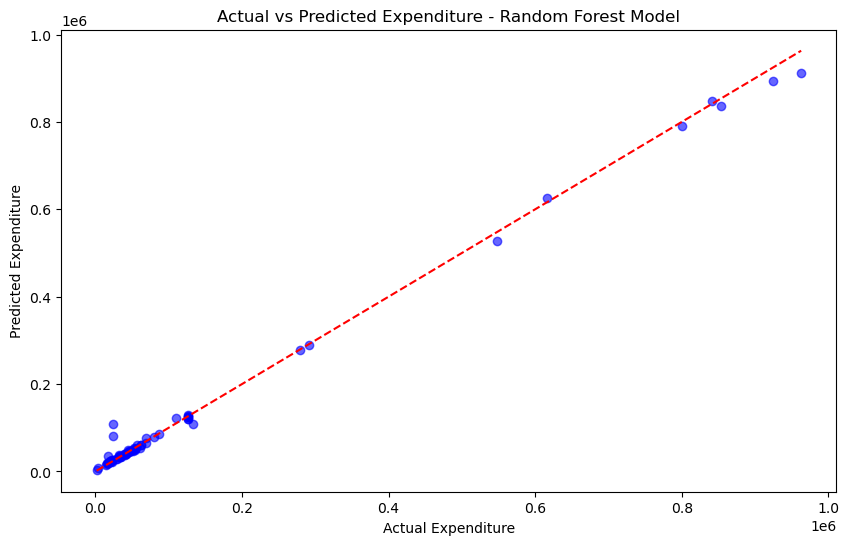

In [16]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Expenditure')
plt.ylabel('Predicted Expenditure')
plt.title('Actual vs Predicted Expenditure - Random Forest Model')
plt.show()

Observations from the Plot:
Most of the blue points are very close to the red dashed line, indicating that the Random Forest model is performing well in predicting expenditure values.
The points form a tight cluster along the dashed line, which shows that predictions are very close to the actual values.
There are no significant outliers, and most predictions align quite well with the actual values, supporting the high $R^2$ score of 0.9956.

Summary of Model Performance:
The plot suggests that the Random Forest model provides highly accurate predictions for expenditure.
The tight clustering of points along the red line indicates that the model has captured the underlying relationships in the data effectively.
The slight deviations from the red line reflect minor prediction errors, but overall, the model shows very good performance.

Key Takeaway:
This visualization supports the idea that the Random Forest model is a good fit for the data, as evidenced by the points being closely aligned with the ideal line (y = x). 
The model’s high $R^2$ value and the accuracy of predictions indicate that it effectively captures the complexity of the expenditure data.

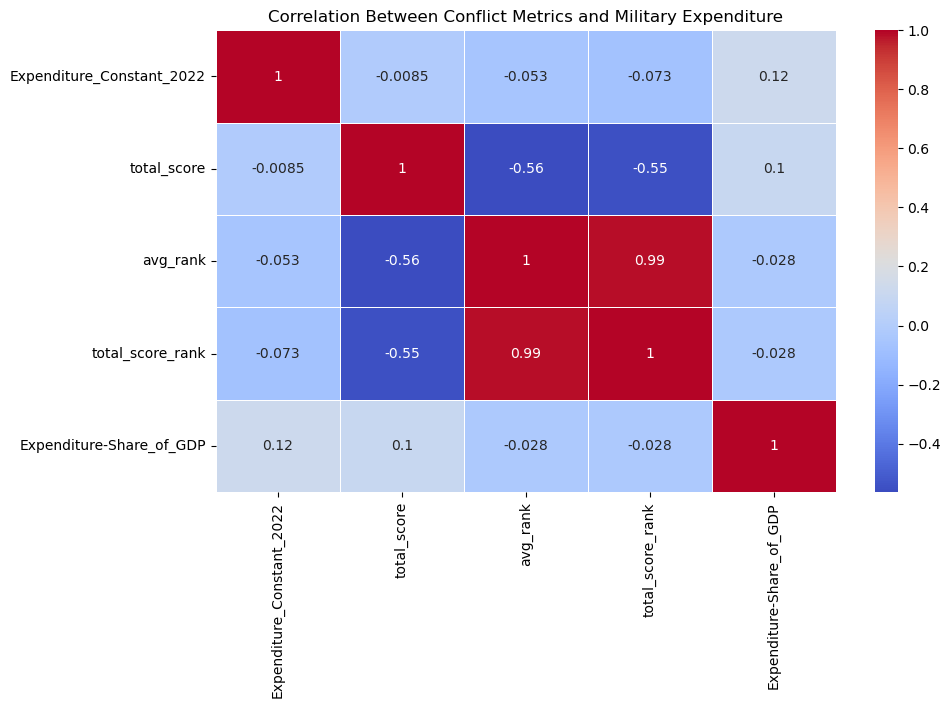

In [17]:
# Correlation Analysis
df_corr = df[['Expenditure_Constant_2022', 'total_score', 'avg_rank', 'total_score_rank', 'Expenditure-Share_of_GDP']]
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Between Conflict Metrics and Military Expenditure")
plt.show()

The heatmap illustrates the correlations between various conflict metrics and military expenditure, including GDP share of military expenditure. Let’s analyze and summarize the key findings from the heatmap:

Summary of Correlations:
Military Expenditure (Expenditure_Constant_2022):

Expenditure_Constant_2022 has weak negative correlations with all the conflict metrics (total_score, avg_rank, total_score_rank), ranging from -0.0085 to -0.073.
There is a weak positive correlation (0.12) between Expenditure_Constant_2022 and Expenditure-Share_of_GDP.
This indicates that the total conflict score and conflict ranking metrics do not significantly influence overall military expenditure. The weak positive correlation with GDP share suggests that as the military budget increases, the proportion of GDP allocated to military may also increase slightly.
Total Conflict Score (total_score):

The total conflict score is negatively correlated with both avg_rank (-0.56) and total_score_rank (-0.55).
It also shows a weak positive correlation (0.1) with Expenditure-Share_of_GDP.
This suggests that as a country’s conflict score increases, it tends to be associated with a lower ranking (more conflict-prone). Higher conflict scores are somewhat related to an increased proportion of GDP being spent on defense, but the relationship is weak.
Average Rank (avg_rank):

avg_rank has a strong positive correlation (0.99) with total_score_rank, suggesting that these two metrics are closely aligned.
avg_rank shows weak negative correlations with Expenditure_Constant_2022 and Expenditure-Share_of_GDP.
This implies that a higher average conflict ranking (lower conflict levels) is not strongly related to a reduction in military expenditure. Instead, the impact on both constant military expenditure and GDP share appears minimal.
Total Score Rank (total_score_rank):

total_score_rank is also strongly correlated with avg_rank (0.99) and shows negative correlations with total_score (-0.55) and Expenditure-Share_of_GDP (-0.028).
The negative correlations indicate that higher conflict rankings (i.e., countries in worse conflict conditions) are associated with higher conflict scores and a very slightly reduced proportion of GDP spent on defense.
Expenditure Share of GDP (Expenditure_Share_of_GDP):

Expenditure_Share_of_GDP has a weak positive correlation with Expenditure_Constant_2022 (0.12) and total_score (0.1), suggesting that as overall military budgets increase or as conflict scores increase, the percentage of GDP devoted to military expenditure slightly increases.
However, Expenditure_Share_of_GDP shows weak negative correlations with avg_rank (-0.028) and total_score_rank (-0.028), indicating that the ranking metrics have minimal impact on the GDP proportion dedicated to military expenditures.
Key Takeaways:
Minimal Impact of Conflict on Military Spending:

The correlations between conflict metrics (like total_score, avg_rank, and total_score_rank) and military expenditure (Expenditure_Constant_2022) are weak.
The low values suggest that conflict intensity is not a primary driver of overall military spending. Military expenditure may be influenced more by economic capacity, strategic defense policies, or other regional/geopolitical factors.
GDP Share and Conflict:

Expenditure-Share_of_GDP shows weak positive correlations with total_score and Expenditure_Constant_2022. This implies that when a country is in more conflict, it may increase defense spending as a proportion of GDP, but the effect is not very strong.
The weak correlations indicate that countries may have limited flexibility in adjusting GDP share for defense in response to conflict, possibly due to economic constraints or existing budget allocations.
Close Relationship Between Conflict Ranking Metrics:

avg_rank and total_score_rank are highly correlated (0.99), indicating that these two metrics are effectively measuring similar aspects of a country's conflict situation.
Both metrics are also moderately correlated with total_score, reinforcing that these ranks closely track the conflict score, but they have little impact on military expenditure.
Economic Context is Crucial:

The weak correlations between conflict metrics and Expenditure-Constant_2022 and Expenditure-Share_of_GDP suggest that economic capacity and strategic priorities are likely more significant factors driving military budgets than conflict intensity alone.
Countries with greater economic capacity may allocate significant absolute amounts to defense without a large share of GDP being impacted, which is why the correlation between conflict and GDP share remains weak.
Overall Reasoning:
The correlation analysis highlights that conflict metrics alone do not significantly drive military expenditure or the share of GDP allocated to defense. Instead, military budgets appear to be influenced by a combination of factors, including economic strength, strategic defense policies, and possibly alliances or regional dynamics. This underscores the importance of looking beyond conflict when analyzing a country's military spending behavior.

#### Analysis Questions

In [18]:
# 1. How does having a high conflict score affect national, regional, and subregional defense spending?
# Extracting the original categorical columns from the one-hot encoded dataframe
region_columns = [col for col in df.columns if 'Region_' in col]
subregion_columns = [col for col in df.columns if 'Subregion_' in col]

df['Original_Region'] = df[region_columns].idxmax(axis=1).str.replace('Region_', '')
df['Original_Subregion'] = df[subregion_columns].idxmax(axis=1).str.replace('Subregion_', '')

# Group by Original Region and Subregion and calculate average expenditure
region_exp = df.groupby('Original_Region')['Expenditure_Constant_2022'].mean()
subregion_exp = df.groupby('Original_Subregion')['Expenditure_Constant_2022'].mean()

print("Average Military Expenditure by Region (in Millions of Dollars):")
print(region_exp)

print("\nAverage Military Expenditure by Subregion (in Millions of Dollars):")
print(subregion_exp)

Average Military Expenditure by Region (in Millions of Dollars):
Original_Region
Americas          13802.785726
Asia & Oceania    13677.990812
Europe             8417.214983
Middle East       10659.050639
Name: Expenditure_Constant_2022, dtype: float64

Average Military Expenditure by Subregion (in Millions of Dollars):
Original_Subregion
Central Europe          1197.844345
East Asia              48620.412128
Eastern Europe         10805.445612
Middle East            10659.050639
North Africa            3384.418351
North America         416188.457695
Oceania                 6487.733853
South America           3918.272636
South Asia             11770.718225
South East Asia         2705.938999
Western Europe         13165.204485
sub-Saharan Africa      1912.795057
Name: Expenditure_Constant_2022, dtype: float64


Summary & Reasoning:
1. Differences in Military Spending Across Regions:
North America has by far the highest average military expenditure at 416,188.46 million dollars, significantly higher than any other region or subregion.

This is reflective of the United States, which has consistently been a global leader in military spending.
East Asia shows the second highest military expenditure, at 48,620.41 million dollars.

This could be due to countries like China, which have been increasing their military budgets in recent years, partially due to regional tensions and strategic expansion.
Western Europe and South Asia also have relatively high average spending, indicating a commitment to defense in regions with historical and ongoing geopolitical challenges.

2. Subregional Variations:
North America (dominated by the US) and East Asia have the highest levels of military expenditure, showing a stark contrast to regions like Central Europe and sub-Saharan Africa, which have much lower spending levels.
Central Europe and sub-Saharan Africa have military expenditures below 2,000 million dollars, suggesting limited military budgets, possibly driven by economic constraints or lower perceived threats.
3. Regional Analysis:
The Americas, Asia & Oceania, and the Middle East have similar military expenditures at around 10,000-14,000 million dollars, while Europe has a slightly lower figure, averaging around 8,417 million dollars.
This indicates a balancing of military budgets across these regions, although North America stands out significantly compared to other subregions.
4. Reasoning Behind Observed Trends:
Economic and Security Factors: The disparities in military spending are largely influenced by both economic capacity and perceived security threats. Wealthier nations like the US have the resources to allocate much larger budgets to defense.
Geopolitical Threats: Regions like East Asia and the Middle East are experiencing ongoing geopolitical tensions, which likely drive up their military expenditures.
Historical Commitments: Countries in Western Europe and North America also have historical commitments to NATO and other military alliances, influencing their budgets.
Key Takeaways:
North America is a major outlier, showing an extremely high level of military spending, driven mainly by the US.
East Asia also has high expenditure, indicating the influence of major players like China.
Regional security needs, economic capabilities, and alliances are major drivers of military spending differences.

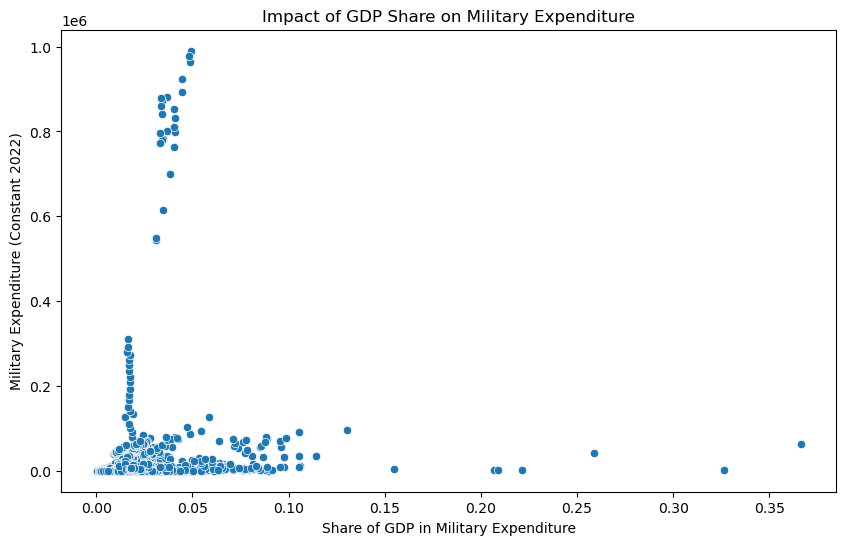

In [19]:
# 2. How does a country's GDP impact its defense spending?
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Expenditure-Share_of_GDP', y='Expenditure_Constant_2022')
plt.title("Impact of GDP Share on Military Expenditure")
plt.xlabel("Share of GDP in Military Expenditure")
plt.ylabel("Military Expenditure (Constant 2022)")
plt.show()

The scatter plot illustrates the relationship between the Share of GDP in Military Expenditure (x-axis) and Military Expenditure in Constant 2022 Dollars (y-axis).

Summary of Observations:
General Pattern:

The plot shows a large concentration of data points around lower values of both GDP share and military expenditure.
The majority of the data points are clustered near 0.00 to 0.05 for GDP share, with military expenditures ranging from relatively low values to nearly 0.2 million in constant 2022 dollars.
Outliers in Spending:

There is a notable cluster of data points at high values of Military Expenditure, specifically around $0.8 to 1 million (in constant 2022 dollars), with GDP share remaining relatively low (close to 0.00).
These high expenditure points represent countries with large defense budgets, but where military expenditure as a percentage of GDP is comparatively small. This scenario is consistent with economically powerful countries that allocate significant amounts to defense while maintaining a low proportion relative to their overall GDP.
Wide Spread at Lower GDP Shares:

There is a wide spread of military expenditure at very low GDP shares. Countries appear to be spending significantly on defense even if the share of GDP allocated is small.
Most countries spend less than 5% of their GDP on military expenditures, and there is a noticeable concentration at near-zero GDP share with varied military expenditures.
Outliers with Higher GDP Share:

There are a few outliers with higher GDP shares (ranging from 0.10 to 0.35). These data points indicate countries that allocate a large proportion of their GDP to military spending, even though the total expenditure amount may not be as high as seen in larger economies.
These outliers might represent nations with ongoing conflicts, security concerns, or comparatively smaller economies, where defense spending becomes a larger percentage of GDP.
Reasoning:
Economic Capacity and Military Spending:

Countries with large economies can afford high levels of military expenditure without these expenditures representing a large proportion of their GDP. This explains the high military spending points around $0.8 million to $1 million but with a low GDP share.
For instance, countries like the United States have a large defense budget, but due to the size of their overall economy, the military expenditure as a percentage of GDP remains relatively low.
High GDP Share Outliers:

Nations with a higher proportion of GDP dedicated to defense (e.g., points around 0.10 to 0.35) are likely countries with heightened security needs or geopolitical tensions. They could also have smaller economies, which makes even moderate military expenditures represent a larger portion of GDP.
These outliers often represent countries experiencing political instability, border conflicts, or high perceived threats, leading them to prioritize defense spending as a proportion of their economic output.
Cluster at Low GDP Share:

The clustering of data points at a low GDP share with varied spending levels suggests that most countries do not allocate large portions of their GDP towards defense. Instead, spending remains relatively moderate in proportion to economic activity, which may reflect more stable geopolitical conditions or effective use of defense alliances (e.g., NATO).
Spending Trends:

There is no strong or consistent trend that indicates that increasing the GDP share consistently translates to higher military expenditure in constant dollars. Instead, the spending levels seem more influenced by other factors, such as economic strength and specific national security needs.
Key Takeaways:
Economically Strong Countries: Economically powerful countries can sustain high defense budgets without it constituting a significant percentage of GDP, as indicated by the high expenditure data points with low GDP shares.

High GDP Share Outliers: A few nations allocate a high proportion of their GDP to defense, likely driven by security concerns or ongoing conflicts. These countries may have smaller economies, so even moderate defense spending results in a high GDP share.

Overall Weak Correlation: There does not appear to be a strong correlation between the share of GDP allocated to military expenditure and the total amount spent. Military spending is determined by a combination of economic capacity, perceived threats, and strategic priorities.

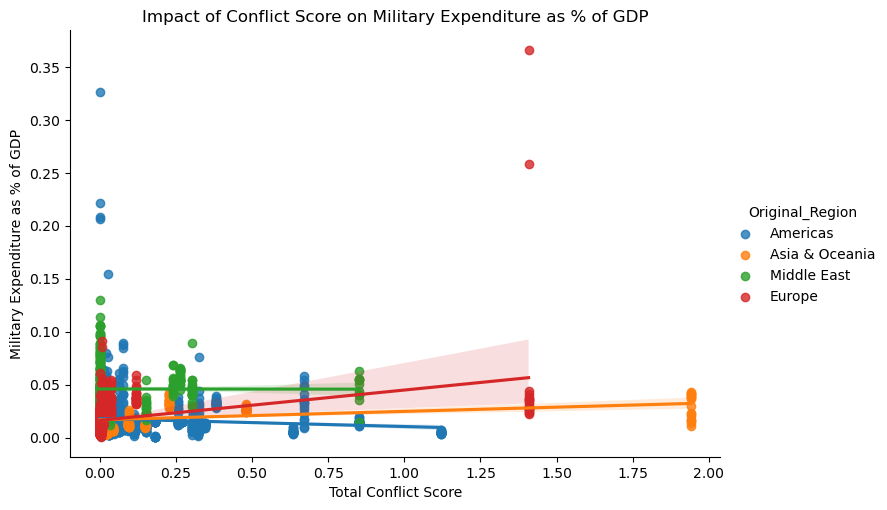

In [20]:
# 3. Does conflict score increase a country's spending as a greater proportion of GDP?
sns.lmplot(data=df, x='total_score', y='Expenditure-Share_of_GDP', hue='Original_Region', aspect=1.5)
plt.title("Impact of Conflict Score on Military Expenditure as % of GDP")
plt.xlabel("Total Conflict Score")
plt.ylabel("Military Expenditure as % of GDP")
plt.show()

The scatter plot presented here visualizes the Impact of Conflict Score on Military Expenditure as a Percentage of GDP, segmented by region: Americas, Asia & Oceania, Middle East, and Europe.

Summary of Observations:
General Pattern:

The plot shows a dispersed relationship between Total Conflict Score (x-axis) and Military Expenditure as % of GDP (y-axis).
The majority of data points are concentrated at lower values for both the conflict score and military expenditure as a percentage of GDP.
The trend lines for each region are mostly flat, indicating a weak relationship between increased conflict scores and increased military spending as a proportion of GDP.
Regional Analysis:

Americas (Blue):
Data points for the Americas cluster primarily at low conflict scores and low military expenditure percentages, generally below 0.05% of GDP.
The trend line is almost flat, indicating that changes in conflict scores have little impact on the proportion of GDP spent on military expenditures.
Asia & Oceania (Orange):
The points are scattered at low conflict scores and generally low military expenditure as a percentage of GDP.
The trend line is almost entirely horizontal, suggesting that the conflict score has minimal influence on military expenditure as a percentage of GDP for countries in this region.
Middle East (Green):
The Middle East shows slightly more variance, with a cluster of data points ranging from low to moderate conflict scores, and military expenditure percentages mostly below 0.10%.
The trend line for the Middle East has a slight upward slope, implying that there is a minor increase in military spending as a percentage of GDP when conflict scores rise. This aligns with the general perception of the Middle East, where ongoing conflicts tend to drive defense spending.
Europe (Red):
The European data points exhibit some variance, with a few outliers at higher military expenditure percentages, particularly at higher conflict scores.
The trend line for Europe is also slightly upward, suggesting that conflict might lead to increased military spending as a proportion of GDP, though this effect is not very strong.
Outliers:

There are a few outliers with significantly higher values of military expenditure as % of GDP, such as the points above 0.25 and 0.35 for the Americas and Europe.
These outliers indicate that in certain cases, a country's military expenditure can form a considerable proportion of its GDP, possibly driven by specific, intense conflicts or national security concerns.
Reasoning:
Weak Correlation Between Conflict Score and Spending:

Across all regions, the trend lines are mostly flat or slightly sloped, which suggests that total conflict score is not a dominant factor in determining military expenditure as a percentage of GDP.
This implies that other factors, such as economic strength, alliances, defense policies, or political stability, may play more significant roles in determining how much of a country’s GDP is allocated to military spending.
Middle East and Europe Show Some Sensitivity:

Middle East and Europe have a slightly positive slope in their trend lines, suggesting that these regions might be more sensitive to conflict levels in terms of increasing defense budgets.
This trend can be explained by ongoing regional conflicts, historical tensions, and security alliances that compel countries in these regions to adapt their military budgets in response to conflicts.
Significance of Outliers:

The outliers showing high percentages of GDP dedicated to military spending could be smaller economies with high military demands or nations with specific threats leading to prioritized defense budgets.
For instance, countries experiencing persistent internal conflicts or external threats may need to allocate a larger portion of their GDP to ensure security, despite having low economic output, thus leading to high military expenditure as a percentage of GDP.
Economic Constraints vs. Conflict:

In many cases, even with increased conflict scores, countries may be limited by their economic capabilities, resulting in low proportional increases in military budgets.
This is particularly noticeable in regions like Americas and Asia & Oceania, where the correlation between conflict score and GDP share is extremely weak, suggesting the influence of broader economic and geopolitical factors that mitigate the effect of rising conflicts.
Key Takeaways:
Weak Influence of Conflict Score: Across all regions, the conflict score seems to have a limited effect on determining military spending as a percentage of GDP. Most countries maintain a consistent proportion of GDP allocated to defense irrespective of conflict levels.

Regional Differences: The Middle East and Europe show slightly more responsiveness to increasing conflict scores, likely due to ongoing regional tensions and geopolitical threats, whereas the Americas and Asia & Oceania have a relatively flat response.

Other Determinants of Spending: This analysis suggests that factors beyond conflict, such as economic stability, international alliances, political leadership, and defense commitments, likely play a more significant role in shaping how much of a country’s GDP is allocated to military spending.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


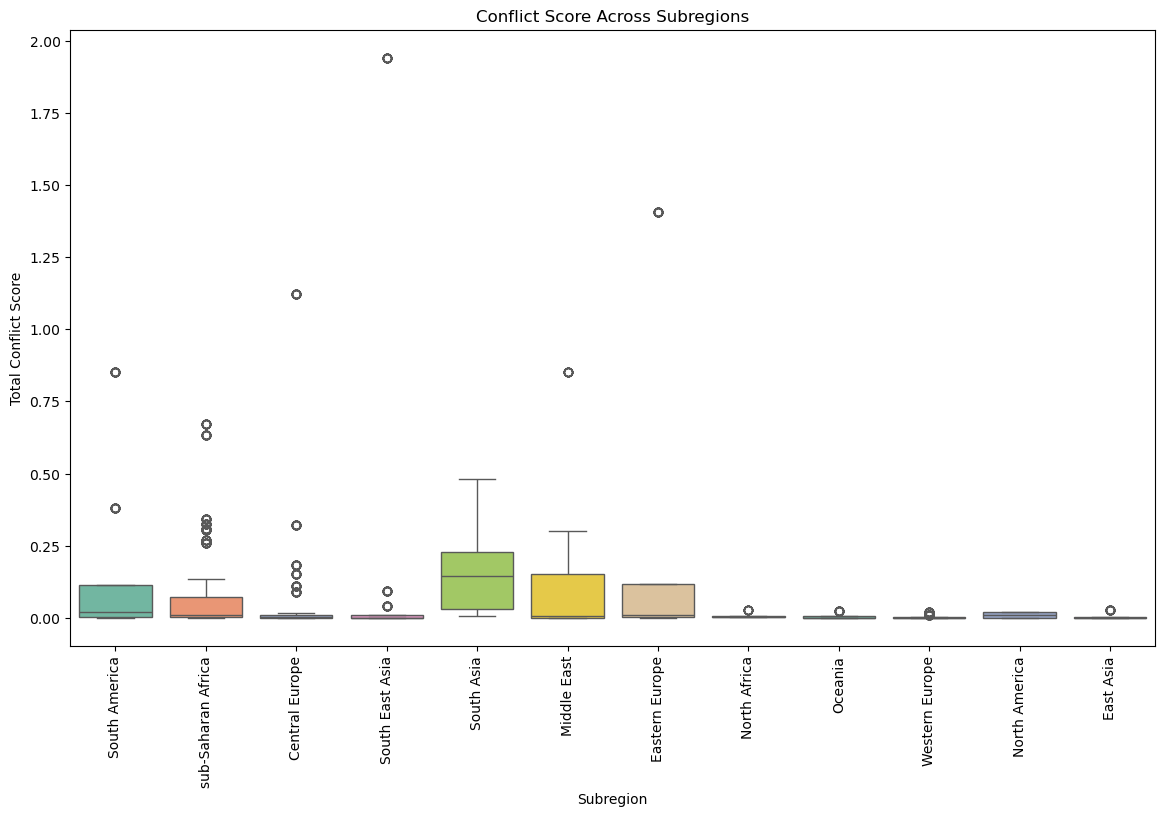

In [21]:
# Visualizing Conflict Impact Across Subregions
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Original_Subregion', y='total_score', hue='Original_Subregion', palette='Set2', dodge=False)
plt.xticks(rotation=90)
plt.title("Conflict Score Across Subregions")
plt.xlabel("Subregion")
plt.ylabel("Total Conflict Score")
plt.legend().remove()
plt.show()

The box plot provides a visualization of the Total Conflict Score across different subregions.

Summary of Observations:
Variability Across Subregions:

South Asia and the Middle East show the highest median conflict scores among all subregions. The interquartile range (IQR) for both subregions is also relatively wide, indicating significant variability in conflict intensity across countries within these regions.
South America and sub-Saharan Africa have moderate median conflict scores but still exhibit significant variability, with numerous outliers extending above the median value.
Central Europe, South East Asia, North Africa, Oceania, Western Europe, North America, and East Asia all show low median conflict scores, and most of these subregions have minimal to no variability in conflict scores. The conflict in these subregions appears to be relatively contained or inactive for the majority of countries.
Presence of Outliers:

South America and sub-Saharan Africa show several outliers, with conflict scores reaching up to 1.25 or even 2.0. These outliers indicate specific countries or instances of severe conflicts that differ significantly from the rest of the subregion.
The Middle East also has some outliers above the upper quartile, highlighting countries that experience heightened conflict compared to the subregional median.
Low Conflict Regions:

Western Europe, North America, and East Asia exhibit very low median conflict scores and a narrow range of values, indicating that most countries in these subregions do not experience significant conflict. This is consistent with the general perception of stability and peace in these regions.
The lack of variability in these subregions suggests a consistent absence of conflict across multiple countries within each subregion.
Reasoning:
Higher Conflict in Specific Subregions:

South Asia and the Middle East are known for ongoing political and territorial conflicts, which is well represented in this visualization. The higher median conflict scores and wider spread indicate that these subregions have multiple countries involved in sustained conflicts. Factors such as historical territorial disputes, insurgency, terrorism, and geopolitical tensions contribute to the heightened conflict levels.
The variability seen in South Asia may be influenced by countries like Afghanistan or Pakistan, where conflict levels vary significantly depending on internal and external political dynamics.
Moderate Conflict in South America and sub-Saharan Africa:

South America and sub-Saharan Africa show considerable variability, with moderate median scores and multiple outliers. This suggests that while some countries in these regions maintain a relatively stable environment, others experience significant conflicts. In South America, this could be due to internal unrest, political instability, and drug-related violence. In sub-Saharan Africa, issues like civil conflicts, insurgencies, and weak governance contribute to the presence of outliers.
Stability in Western Europe, North America, and East Asia:

The low conflict scores observed for Western Europe, North America, and East Asia reflect a stable geopolitical situation in these subregions, likely influenced by strong governance, effective regional alliances, and economic stability.
The absence of variability indicates that conflicts are minimal and evenly distributed among countries within these subregions, contributing to an overall atmosphere of peace and stability.
Outliers Represent Severe Conflict Situations:

The outliers in South America, sub-Saharan Africa, and the Middle East likely represent specific countries facing severe and prolonged conflicts, which are not typical of the rest of the subregion. These countries may be grappling with civil wars, political instability, or intense security challenges that lead to a spike in their conflict scores.
Key Takeaways:
South Asia and the Middle East show high conflict levels, with notable variability, indicating widespread regional instability, but with pockets of even more severe conflict.
South America and sub-Saharan Africa have moderate median conflict scores, but significant outliers suggest specific regions are facing intense localized conflicts.
Western Europe, North America, and East Asia demonstrate low conflict levels and consistent stability across countries, reflecting a lack of significant geopolitical conflicts.
The presence of outliers is key to understanding that not all countries within a subregion experience the same level of conflict—highlighting the importance of analyzing specific country situations when interpreting regional data.

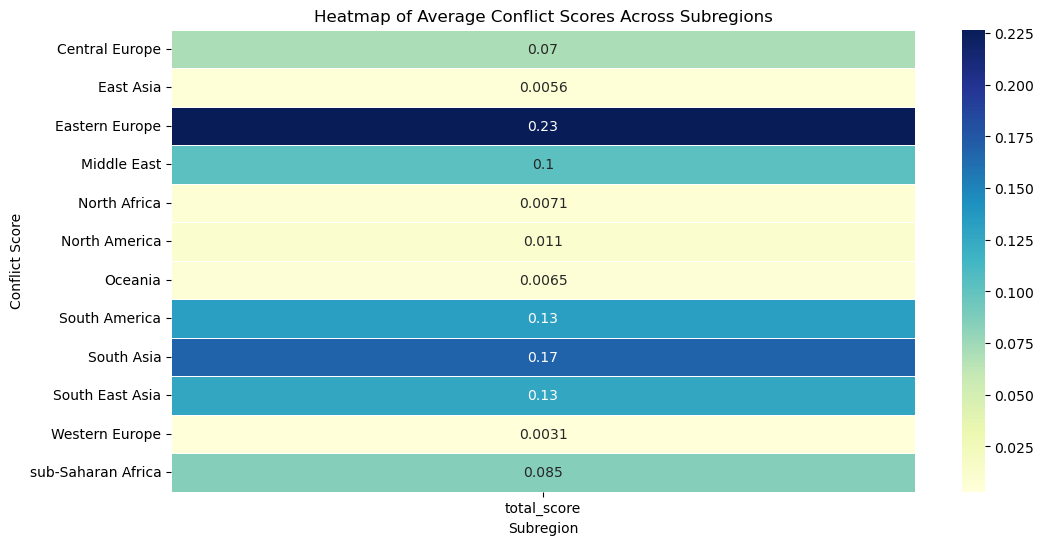

In [22]:
# Creating Heatmap for Conflict Scores Across Subregions
conflict_pivot = df.pivot_table(values='total_score', index='Original_Subregion', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.heatmap(conflict_pivot, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title("Heatmap of Average Conflict Scores Across Subregions")
plt.xlabel("Subregion")
plt.ylabel("Conflict Score")
plt.show()

The heatmap shows the average conflict scores across different subregions. Each subregion is represented by its respective average conflict score, visually indicated by the color gradient, with darker colors representing higher conflict levels. Let’s summarize and analyze the findings:

Summary of Observations:
High Conflict Subregions:

Eastern Europe shows the highest conflict score with a value of 0.23, represented by the darkest shade on the heatmap.
South Asia also shows a relatively high conflict score (0.17), indicating moderate to high levels of conflict intensity in this subregion.
These regions appear in darker shades, implying higher conflict intensities compared to other subregions.
Moderate Conflict Subregions:

Middle East has an average conflict score of 0.1, indicating a significant, though moderate, conflict level.
South America and South East Asia both have scores of 0.13, showing moderate conflict situations.
These regions have conflict levels slightly below that of Eastern Europe and South Asia, suggesting that while conflict is present, it may not be as widespread or severe.
Low Conflict Subregions:

Central Europe, sub-Saharan Africa, North America, North Africa, East Asia, Western Europe, and Oceania show low conflict scores, ranging from 0.0031 to 0.085.
East Asia and Western Europe have notably low conflict scores (0.0056 and 0.0031 respectively), suggesting these regions are relatively peaceful.
The lightest colors on the heatmap correspond to these regions, indicating the relatively low intensity of conflict across these subregions.
Key Insights:
Eastern Europe as the Highest Conflict Region:

Eastern Europe has the highest average conflict score (0.23), which is consistent with the ongoing geopolitical tensions in this subregion. The presence of conflict in places like Ukraine and other parts of Eastern Europe has led to increased conflict metrics, hence the darker shade in the heatmap.
The elevated conflict score in Eastern Europe could be driven by both interstate conflicts and political instability.
South Asia and Middle East:

South Asia also stands out with a higher conflict score (0.17), which can be attributed to several ongoing issues, including territorial disputes, internal insurgencies, and political instability in countries such as Afghanistan and Pakistan.
The Middle East also shows a moderate conflict level (0.1). This aligns with the ongoing conflicts and tensions in countries such as Syria, Yemen, and other parts of the Middle East, which contribute to a sustained level of conflict in this region.
Relatively Low Conflict in Other Subregions:

Subregions like North America, Western Europe, and East Asia display very low average conflict scores, which is indicative of their stability and security. These regions benefit from strong political institutions, alliances (such as NATO), and relatively fewer active conflicts.
Oceania and North Africa also show minimal conflict, suggesting a relatively stable environment despite some regional challenges.
Sub-Saharan Africa and Central Europe:

sub-Saharan Africa and Central Europe show average conflict scores of 0.085 and 0.07, respectively. Although sub-Saharan Africa is known for local conflicts and instability, it appears that the conflicts are more localized rather than pervasive across the entire subregion.
Central Europe shows a low conflict score, which suggests that the region is largely peaceful despite some nearby geopolitical tensions.
Reasoning:
The color gradient in the heatmap effectively highlights the geographical disparities in conflict intensity. Darker colors show higher conflict levels, which are mainly seen in Eastern Europe, South Asia, and South America.
Economic and Geopolitical Factors likely play a significant role in these differences:
Eastern Europe and South Asia are characterized by both ongoing conflicts and territorial disputes, which contribute to their higher scores.
Western Europe, North America, and East Asia, on the other hand, are largely peaceful, benefiting from stronger governance and collective security agreements that contribute to a lower average conflict score.
Moderate Conflict Regions like South America, South East Asia, and the Middle East indicate that while these subregions are not entirely stable, conflict is generally not as widespread or severe as in Eastern Europe.
Conclusions:
Eastern Europe and South Asia have the highest conflict levels among all the subregions, suggesting greater geopolitical instability.
Western Europe, North America, and East Asia show the lowest conflict scores, indicating strong stability and minimal conflict.
The Middle East continues to display moderate conflict levels, which reflect the ongoing issues and conflicts in the region.

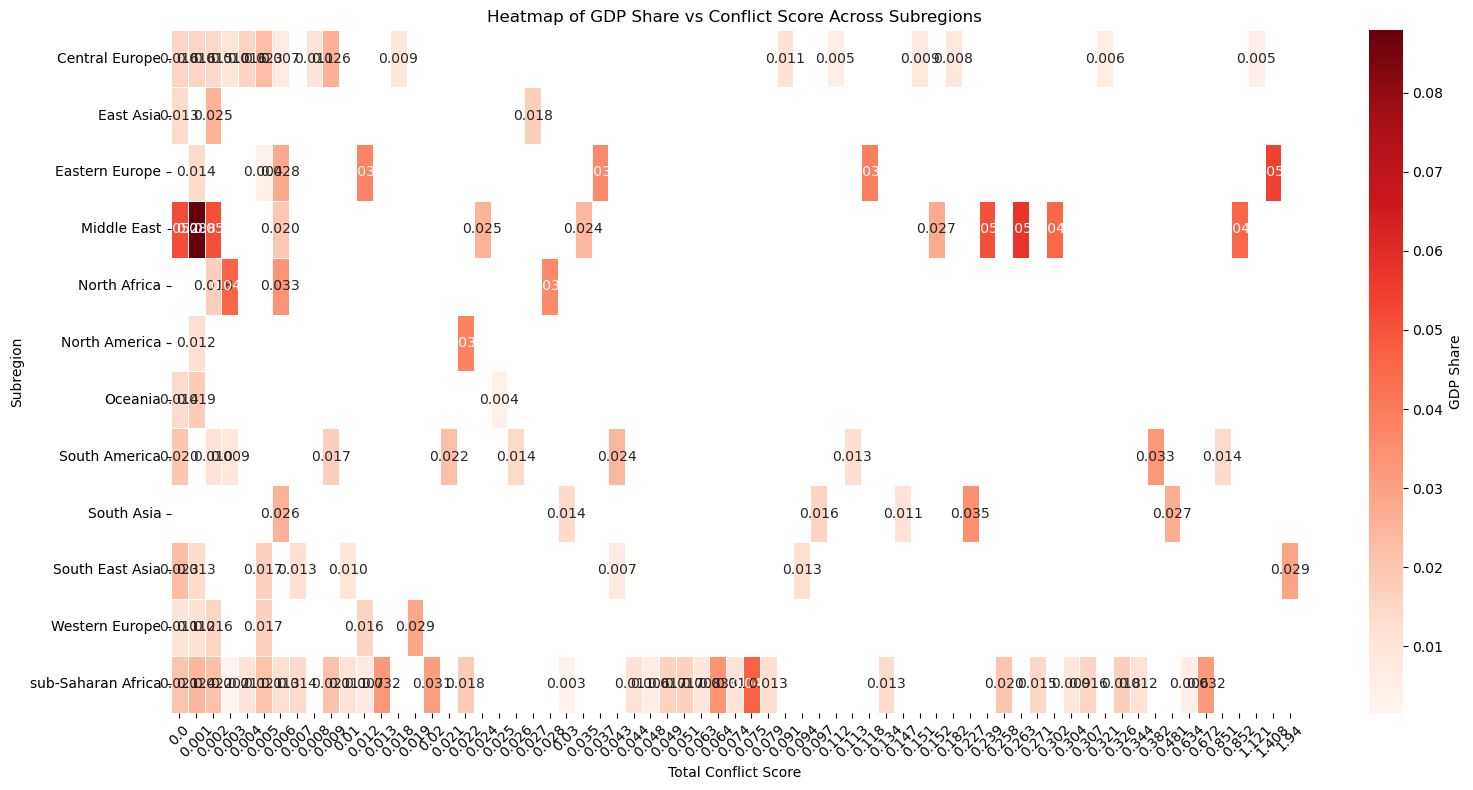

In [23]:
# Creating Heatmap for GDP Share vs Conflict 
gdp_conflict_pivot = df.pivot_table(values='Expenditure-Share_of_GDP', index='Original_Subregion', columns='total_score', aggfunc='mean')
plt.figure(figsize=(16, 8))
sns.heatmap(gdp_conflict_pivot, annot=True, cmap='Reds', linewidths=0.5, fmt='.3f', cbar_kws={'label': 'GDP Share'})
plt.title("Heatmap of GDP Share vs Conflict Score Across Subregions")
plt.xlabel("Total Conflict Score")
plt.ylabel("Subregion")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The heatmap illustrates the relationship between GDP Share dedicated to military expenditure and Conflict Score across various subregions. Each cell represents the average GDP share for a given conflict score within a particular subregion, with the color indicating the magnitude (from lighter to darker red). Let’s analyze this visualization and provide a summary:

Summary of Observations

General Trends:
The heatmap indicates that there is variation in the GDP share dedicated to military expenditure across different conflict levels and subregions.
Darker shades of red indicate a higher percentage of GDP spent on defense in response to increasing conflict scores, whereas lighter shades indicate a lower GDP allocation to defense spending.
The variation across subregions suggests that regional economic and security circumstances affect how much a country chooses to allocate its GDP towards military spending in response to conflict.
Subregions with High GDP Share in Response to Conflict:

Middle East: The Middle East shows relatively high levels of GDP being allocated to military expenditure, especially as conflict scores increase. This is represented by the darker red shades, particularly in the 0.1 - 0.5 conflict score range.

This is consistent with the geopolitical instability in the region, where countries often have to spend a significant proportion of their GDP on defense to respond to regional conflicts and perceived threats.
Eastern Europe: Similarly, Eastern Europe displays significant increases in GDP share in the face of rising conflict scores, particularly around 0.23. This can be attributed to ongoing tensions and geopolitical issues, such as those related to border security and conflicts in regions like Ukraine.

North Africa and South Asia: These subregions also show a noticeable increase in GDP share as conflict levels rise, particularly in scores between 0.03 - 0.05 for North Africa and 0.02 - 0.03 for South Asia. These areas are often subject to political instability, insurgencies, and regional tensions, prompting governments to allocate higher portions of their GDP towards military spending.

Subregions with Consistently Low Defense Spending:

Western Europe, East Asia, North America, and Oceania show consistently lower levels of GDP share dedicated to military spending, even as conflict scores increase. The light colors for these regions indicate that the overall expenditure as a percentage of GDP remains low despite varying conflict levels.
This reflects the generally stable security environments in these subregions, where countries do not need to allocate a significant portion of their GDP to military expenditure due to strong governance, stability, and often being part of defense alliances like NATO.
Central Europe and sub-Saharan Africa show lower military spending as a percentage of GDP, even at higher conflict scores. This may reflect economic constraints or strategic decisions to prioritize non-military investments.
Subregion-Specific Observations:

South America: The heatmap shows moderate increases in GDP share in response to conflict in South America, especially as the conflict score reaches 0.1. However, these levels remain relatively low compared to other subregions like the Middle East.
South East Asia: South East Asia has moderate allocations, with GDP share rising slightly with higher conflict scores, indicating some sensitivity to conflict but generally remaining more stable compared to high-conflict subregions.

Key Insights:

Regional Differences in Defense Spending as a Function of Conflict:

The Middle East and Eastern Europe show the highest sensitivity to conflict scores, as indicated by the higher GDP allocations (darker red shades). This suggests that countries in these regions are willing to increase military expenditure as a response to heightened conflict levels.

Subregions like Western Europe and North America show less variation and consistently low GDP shares allocated to defense, implying that their defense budgets are less responsive to conflict intensity, likely due to stable security environments and effective alliances.

Economic Constraints and Prioritization:

Some subregions, such as sub-Saharan Africa, despite experiencing conflict, have low GDP allocations for defense. This may be attributed to economic constraints where countries cannot afford significant military expenditure, even in the face of conflict. On the other hand, the Middle East uses its oil wealth to sustain high defense budgets, reflecting the prioritization of security given the region's volatility.
Influence of Alliances and Stability:

Western Europe, being largely part of NATO, shows minimal changes in GDP share across various conflict scores. This suggests that countries in this region can maintain a stable defense posture without drastically changing their spending habits, benefiting from collective security mechanisms. In contrast, regions like Eastern Europe are more directly affected by geopolitical tensions, leading to more significant GDP allocations to defense.

Conclusion:
The heatmap provides a clear indication of how different subregions respond to conflict in terms of their military expenditure as a share of GDP. Subregions experiencing higher geopolitical instability (e.g., Middle East, Eastern Europe) tend to allocate more of their economic output towards defense as conflict scores rise.
Stable regions like Western Europe, North America, and Oceania are less likely to increase their GDP share for military purposes, relying instead on established security measures and alliances.
The variability across subregions can be attributed to economic capacity, strategic prioritization, and regional security dynamics, highlighting that defense spending in response to conflict is influenced by both internal economic factors and external threats.

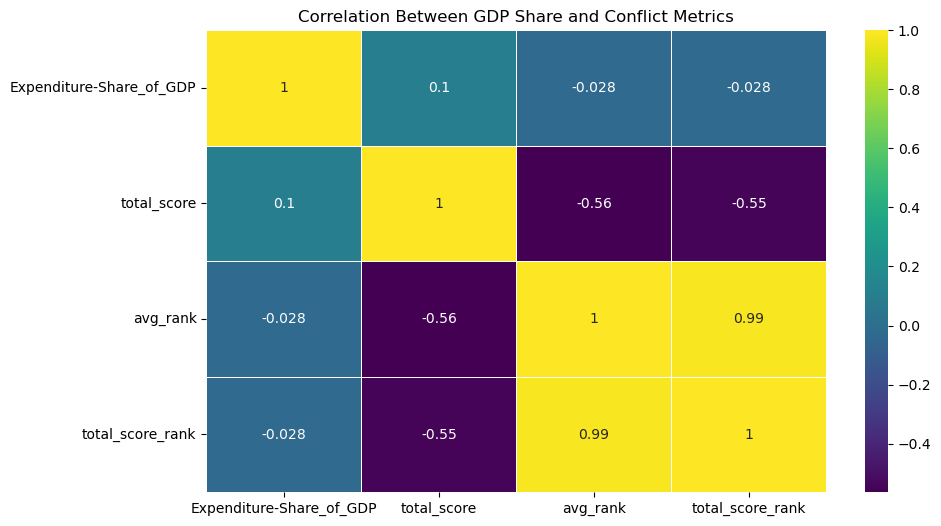

In [24]:
# Analyzing Correlations Between GDP and Conflict
gdp_conflict_corr = df[['Expenditure-Share_of_GDP', 'total_score', 'avg_rank', 'total_score_rank']]
plt.figure(figsize=(10, 6))
sns.heatmap(gdp_conflict_corr.corr(), annot=True, cmap='viridis', linewidths=0.5)
plt.title("Correlation Between GDP Share and Conflict Metrics")
plt.show()

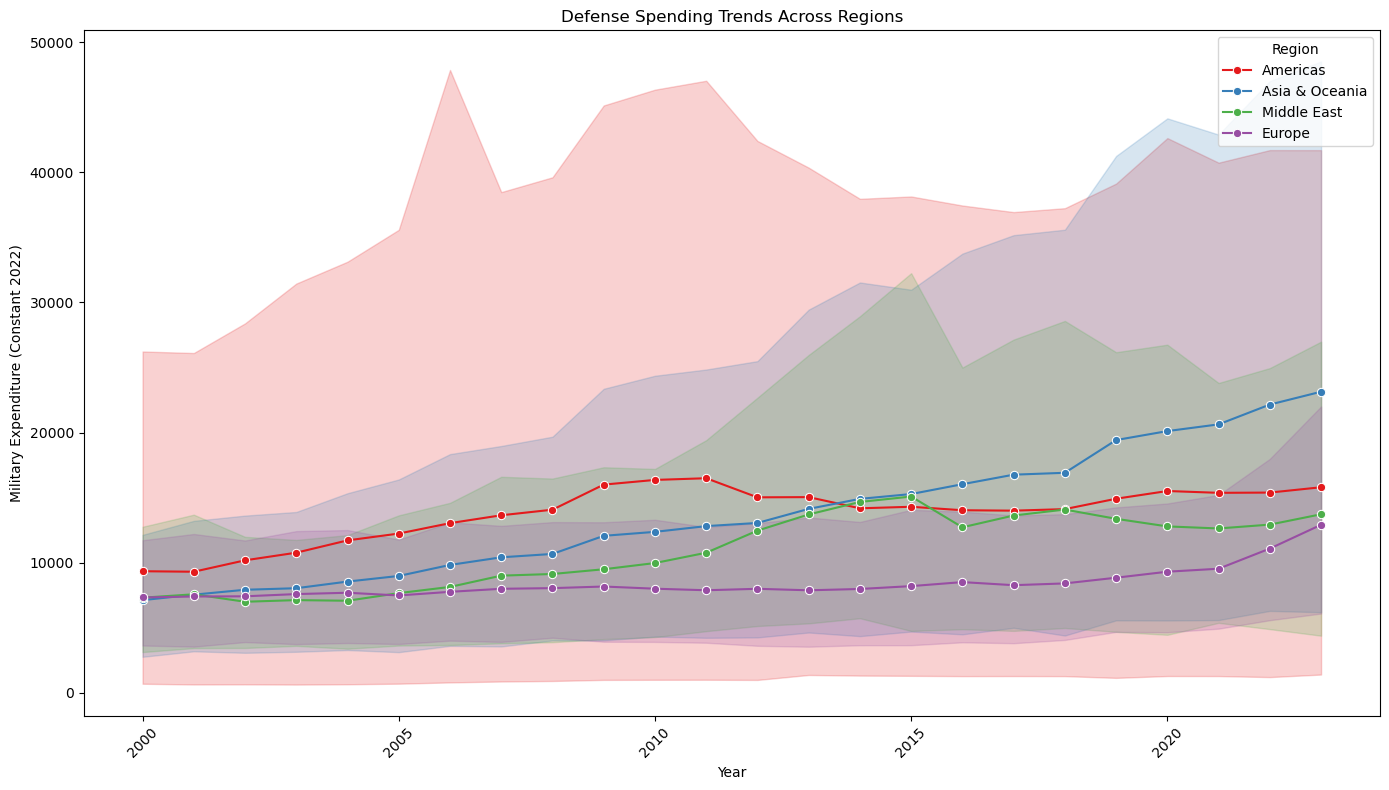

In [25]:
# Visualizing Defense Spending Trends Across Regions
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='Year', y='Expenditure_Constant_2022', hue='Original_Region', marker='o', palette='Set1')
plt.title("Defense Spending Trends Across Regions")
plt.xlabel("Year")
plt.ylabel("Military Expenditure (Constant 2022)")
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.show()

Americas (Red Line):
The Americas shows consistently high defense spending, which is unsurprising given the significant contribution from the United States.
The trend line is relatively stable with a slight increase over time, indicating that military budgets in the Americas have been sustained at high levels, with some minor fluctuations.

Americas (Red Area):
The Americas have a relatively wide shaded area, which indicates that there are significant fluctuations or variability in military spending. This could be due to factors such as policy changes, budget reallocation, or responses to global or regional events. The shaded area also reflects occasional peaks, which could be due to increased defense budgets during particular years, possibly driven by major military campaigns or increased security needs.

Asia & Oceania (Blue Line):
The Asia & Oceania region has shown a gradual increase in defense spending, especially from around 2010 onwards. This growth may reflect the increasing defense budgets of countries like China, India, and other countries in the region focusing on enhancing their military capabilities.
The expenditure is now one of the highest among the regions, indicating significant growth and a focus on security in recent years.

Asia & Oceania (Blue Area):
The Asia & Oceania region also has a noticeable shaded area, which implies some variability in the defense spending. As military budgets have grown over the years, there might be a broader range of investments made by individual countries, contributing to this variability.

Middle East (Green Line):
The Middle East shows a significant and rapid rise in defense spending from 2005 onwards, reaching a peak around 2015.
This rise can be attributed to regional conflicts, geopolitical instability, and the increasing militarization of countries like Saudi Arabia, United Arab Emirates, and other Gulf nations. However, post-2015, spending levels seem to stabilize or even slightly decrease, reflecting adjustments to the changing geopolitical landscape.

Middle East (Green Area):
The Middle East shows significant variability, especially during the peak years between 2005 and 2015. The wide shaded area suggests that defense budgets in this region can fluctuate sharply, likely due to the dynamic and often volatile geopolitical environment. Changes in government, oil revenues, and direct involvement in conflicts are factors that can result in high spending variation.

Europe (Purple Line):
Europe shows relatively stable defense spending with a gradual but slow increase over the years.
European countries are part of alliances such as NATO, and the spending here reflects moderate growth in military budgets, influenced by both internal and external security considerations.

Europe (Purple Area):
The shaded area for Europe is relatively narrow, which suggests lower variability in defense spending. This indicates that defense spending in Europe has been more consistent over time, potentially due to shared NATO obligations and a stable political and economic environment. This consistency in spending reflects the European countries' focus on stability and reliance on collective security measures rather than fluctuating individual defense budgets.


Significant Growth in Asia & Oceania:
The most noticeable trend is the steady and steep rise in Asia & Oceania's military expenditure. This trend suggests an increased emphasis on military modernization and preparedness in response to regional security threats, such as territorial disputes in the South China Sea, and the growing influence of China.
The growth in expenditure reflects broader strategic goals of many Asian countries to strengthen their military forces and play a more significant role in global security.

Stability in Americas:
The Americas maintains a high level of defense spending, which is largely driven by the United States, the country with one of the largest military budgets globally.
The stable trend suggests a consistent focus on maintaining a high level of military readiness and sustaining a broad military presence globally.

Surge in the Middle East:
The sharp increase in Middle Eastern defense spending from 2005 to 2015 coincides with several conflicts and rising tensions in the region, including the conflicts in Iraq, Syria, and Yemen.
This spike reflects the strategic need for regional countries to bolster their military capabilities during a time of increased instability, proxy wars, and changing power dynamics.
Moderate Spending in Europe:

Europe's relatively stable trend in defense spending, with only a modest increase, likely reflects a balance between maintaining adequate defense capabilities and focusing on economic challenges.
The influence of collective defense agreements, like NATO, allows many European countries to manage their individual defense spending without significant yearly increases.

Geopolitical and Economic Context

Geopolitical Threats and Rivalries:
The rise in military spending across Asia & Oceania and the Middle East can be linked to perceived threats, increased territorial disputes, and the strategic desire to gain influence in the region. As China expands its capabilities, neighboring countries such as India and Japan have responded by increasing their defense budgets.
In the Middle East, spending is heavily influenced by geopolitical rivalries, particularly between Saudi Arabia and Iran, and the ongoing need to manage internal and regional security threats.

Economic Capacity:
Defense spending trends are also closely linked to economic capacity. For example, the United States has a vast economic base that allows it to sustain high defense budgets, while Middle Eastern countries benefit from oil revenues that fund their military expenditures.
In Europe, defense spending has been impacted by economic policies, and member countries rely heavily on NATO partnerships rather than dramatic increases in their individual defense budgets.
Regional Alliances:
The influence of alliances like NATO in Europe has kept military expenditure moderate. Shared resources and collective security arrangements mean that European countries can maintain lower defense budgets without compromising their security posture.

Key Takeaways:
Asia & Oceania and the Middle East exhibit strong upward trends in defense spending, reflecting rising tensions and efforts to enhance military capabilities.
Americas maintains consistently high levels of military expenditure, driven by the United States, showing the emphasis on global military presence and readiness.
Europe shows moderate increases in defense spending, indicating a stable approach focused on gradual improvements rather than rapid militarization.

<div class="alert alert-block alert-info">

**References**

https://scikit-learn.org/stable/supervised_learning.html

Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media, 2019.

Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5-32.

ChatGPT, (2024) GPT-4o version, OpenAI. [Large language model]. https://chatgpt.com/

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models. Cambridge University Press.

Guyon, I., & Elisseeff, A. (2003). An Introduction to Variable and Feature Selection. Journal of Machine Learning Research, 3(Mar), 1157-1182.

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 

LinearRegression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Ridge Regression. scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html 

GradientBoostingRegressor https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

CountVectorizer. scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Train-Test Split. scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
</div>
